This notebook is a walk through of the filtering aspect of analysis to get Ben set up to optimize it a little more than my "looks good bro" approach

In [2]:
"""
A collection of functions to perform a dark photon search on an averaged spectrum


Functions
-------
median_filt(
    
):
    LPF for spectrum. Recomended as a pre-filter if
    spec contains large, very narrow candidates

butter_filt(

):
    LPF for spectrum. 

SG_filt(

):
    LPF for spectrum


"""
import numpy as np 
import scipy.signal as spsig
import scipy.ndimage as spim
import cupyx.scipy.ndimage as cpim
import cupy as cp
from scipy.signal import butter, filtfilt
import scipy.stats
import scipy.special
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib widget


def median_filt(spec, filter_size=50):
    """
    Function to apply median filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    filter_size : int, optional
        Size of the median filter. Default is 50.

    Returns
    -------
    spectrum_filtered : array
        The median-filtered spectrum.
    """
    spectrum_gpu = cp.array(spec)
    spectrum_filtered_gpu = cpim.median_filter(
        spectrum_gpu,
        size=(filter_size),
        origin=0
    )
    spectrum_filtered = spectrum_filtered_gpu.get()
    return spectrum_filtered

def butter_filt(spec, cutoff=40000, order=6):
    """
    Function to apply Butterworth low-pass filtering to a spectrum.

    Parameters
    ----------
    spectrum : array
        The input power spectrum.

    cutoff : int, optional
        Cutoff frequency for the filter. Default is 40000.

    order : int, optional
        Order of the filter. Default is 6.

    Returns
    -------
    spectrum_filtered : array
        The Butterworth low-pass filtered spectrum.
    """
    nyq = 0.5 * len(spec)  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    spectrum_filtered = filtfilt(b, a, spec)
    return spectrum_filtered

def sg_filt(spec, window_length=51, polyorder=4):
    """
    Apply a Savitzky-Golay filter to the spectrum.

    Parameters
    ----------
    window_length : int, optional
        Length of the filter window; must be a positive odd integer, default is 51.
    polyorder : int, optional
        Order of the polynomial used to fit the samples, default is 1.

    Returns
    -------
    arr
        Filtered spectrum.
    """
    spectrum_filtered = spsig.savgol_filter(spec, window_length=window_length, polyorder=polyorder)
    return spectrum_filtered


def lam(nu, nu0, p0 = None, nBins=None, v0=220, vlab=233, offset = 0):
    """
    Lambda function for matched filtering.
    Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    velocity args in km/s
    vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    output is normilized to p0 if given

    Parameters
    ----------
    nu : float
        Frequency.
    nu0 : float
        Center frequency.
    p0 : float, optional
        Power normalization value, default is None.
    nBins : int, optional
        Number of bins, default is None.
    v0 : int, optional
        Velocity parameter, default is 220.
    vlab : int, optional
        Lab velocity parameter, default is 233.
    offset : int, optional
        Frequency offset, default is 0.

    Returns
    -------
    tuple
        Frequencies and output power spectral density.
    """
    if nBins is not None:
        # find the index of nu0 in nu array
        idx = np.abs(nu-nu0).argmin()

        # calculate the slice start and end indices
        start_idx = max(0, idx - nBins//2)
        end_idx = min(len(nu), idx + nBins//2)
        nu = nu[start_idx:end_idx]

    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    lamArr  = a*np.exp(b)*np.sinh(beta)
    if p0 is not None:
        outPSD = p0/np.sum(lamArr) * lamArr #normilize to p0
    else:
        outPSD = lamArr

    return nu, outPSD 

def freq2idx(freq, freqs):
    return int(freq/freqs[-1]*len(freqs))


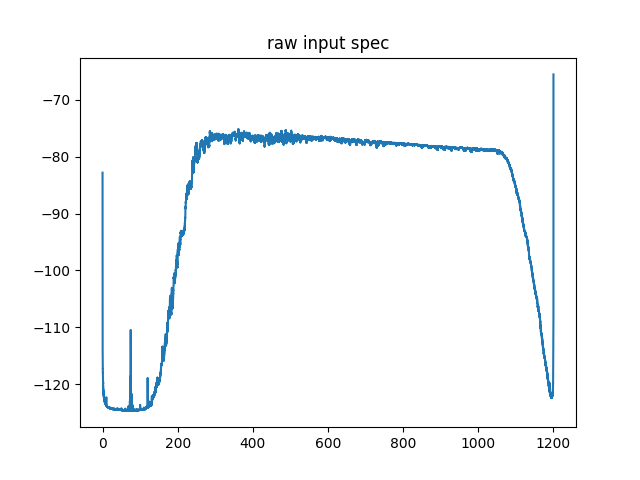

In [9]:
#test data

#DP signal
nBins       = 100
p0          = 50e-15
nu0         = 250 #79.72012
lamOut      = lam(freqs, nu0, p0, nBins=None, offset=-0e-6)
lamArr      = lamOut[1] # len N_bins array of almost all 0s with a narrow lambda line shape

#load real data here. Change path!
########################################

# chB_avg_W_switch0.npy 
#   is basically the real run1.4 data set
#   It is the average of all the data, but technically we throw 
#   out the first three spectra after every antenna move
#
if 0: 
    spec    = np.load('/drBiggerBoy/run1p4/plottingSpec/chB_avg_W_switch0.npy')[1:]
    freqs   = np.linspace(0, 400, 2**23)

# 12hrRun_4dBatt_9_6_23.npy 
#   single antenna position from the run 1B set up
#   It's a pickled dict so it's goofy to load, see below.
if 1:
    spec    = np.load('/drBigBoy/darkRadio/daqAnalysisAndExperiments/run1B/daq/systemTesting/data_gitignore/12hrRun_4dBatt_9_6_23.npy', 
        allow_pickle = True).item()['chBSpec_W'][1:]
    freqs   = np.linspace(0,1200,2**22)



#inject signal
spec += lamArr



#test data
testDataFlag = 0 #if 0 use data loaded above.
#you can probably remove this logic, I used it for something in analysisClass.ipynb

if testDataFlag:
    if 1: #wacky H with janky signal injection. Prob dont use this one
        frequency = np.linspace(0, 400, 2**23)  # frequency range

        freqStart       = .5
        freqStop        = 9.5
        idxStart        = freq2idx(freqStart, frequency)
        idxStop         = freq2idx(freqStop, frequency)

        undulation = 0*np.sin(frequency * 100) + frequency*0 +100 # sinusoidal signal
        noise = np.random.normal(10, .01, frequency.shape)  # Gaussian noise
        noise[2**20:2**20+6] = 11.2
        spec = (undulation * noise)  # noisy spectrum

    if 0:
        #chirp    
        np.random.seed(0)  # for reproducibility
        freqs = np.linspace(0, 400, 2**23)  # frequency range
        undulation = spsig.chirp(freqs, 1/800, freqs[idxStop], 1/.1) + 100
        noise = np.random.normal(10, .01, freqs.shape)  # Gaussian noise
        noise[2**20:2**20+10] = 10.05
        spec = (undulation * noise)  # noisy spectrum


plt.close('all')


plt.figure()
plt.title('raw input spec')
plt.plot(freqs, 10*np.log10(spec*1000))
plt.show()






In [11]:
medFiltSpec     = median_filt(spec, 50)
filtSpec        = butter_filt(medFiltSpec)

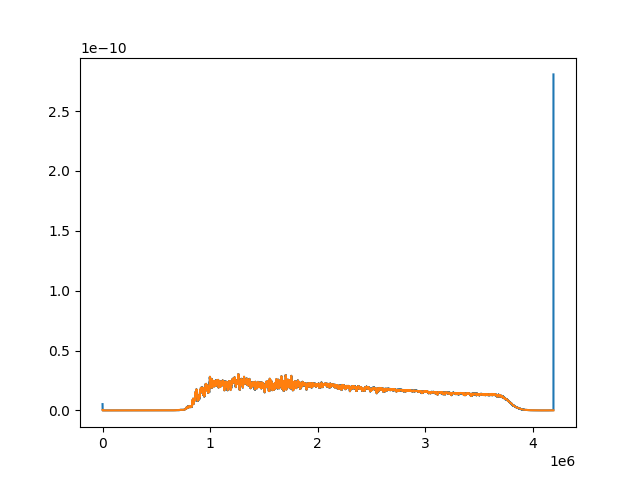

In [14]:
plt.close('all')
plt.figure()
plt.plot(spec)
plt.plot(filtSpec)

#Have fun!